In [1]:
import torch
import sys
import os
from pathlib import Path
import csv
import yaml

# append the current path
ROOT = Path.cwd().resolve().parents[0]
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from utils import *
from utils import get_all_preds, plot_confmat, plot_gradcam, plot_results
from dataset.data import get_transforms, load_dataset
from train import get_num_correct


In [2]:
# checkpoints files path
def get_ckpt(model, get_state_dict = False):
    ckpt = f"../weights/Runs/weights/lr3e-5_{model}_cuda.pth"
    if get_state_dict:
        model_info = torch.load(ckpt, map_location= torch.device("cpu"))
        epoch = model_info["epoch"]
        model_sd = model_info["model_state_dict"]
        return ckpt, model_sd
    return ckpt


In [3]:
# test path..
path = get_ckpt("resnet18")
if os.path.exists(path):
    print("Yes, the path exits")
else:
    print("Oops! the path doesnt exists")


Yes, the path exits


In [4]:
config_file = "../configs/configs.yaml"
with open(config_file, "r") as f:
    cfg = yaml.safe_load(f)
# print(cfg)

In [5]:
# set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# data loaders
train_loader = load_dataset(config_file= cfg, batch_size= 32, 
                            kind= "train", drop_last = False)
test_loader = load_dataset(config_file=cfg, batch_size=32, 
                           kind = "test", drop_last = False)

### pick the model
- loading the ckpt 
- evaluating resnet18 performance
- plotting results and confusion matrix

In [7]:
updated_model = get_model("vgg16", pretrained=False,
                      num_classes=4, weights= get_ckpt("vgg16", get_state_dict=True)[1])


In [8]:
train_predictions, train_labels = get_all_preds(updated_model, train_loader)
test_predictions, test_labels = get_all_preds(updated_model, test_loader)

In [9]:
# check dimensions of each prdiction
print("Training predict ion: {}".format(train_predictions.shape))
print("Test predictions: {}".format(test_predictions.shape))

Training predict ion: torch.Size([20685, 4])
Test predictions: torch.Size([240, 4])


In [10]:
train_corrects = get_num_correct(train_predictions, train_labels )
test_corrects = get_num_correct(test_predictions, test_labels)

print(f'Train Correct: {train_corrects:5}\tTrain Accuracy: {(100*train_corrects/len(train_loader.dataset)):5.2f}%')
print(f'Test Correct: {test_corrects:6}\tTest Accuracy: {(100*test_corrects/len(test_loader.dataset)):6.2f}%')

Train Correct: 20096	Train Accuracy: 97.15%
Test Correct:    226	Test Accuracy:  94.17%


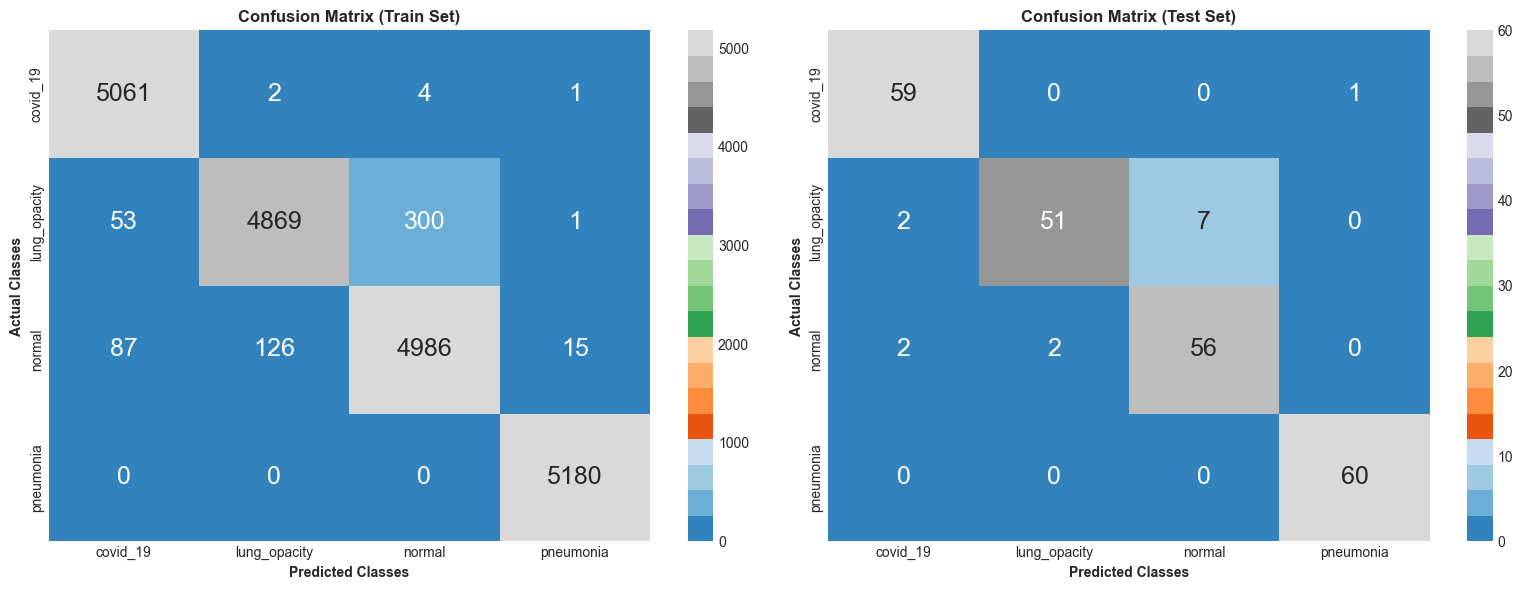

In [11]:
train_confmat =get_confmat(train_labels, train_predictions)
test_confmat = get_confmat(test_labels, test_predictions)
plot_confmat(train_confmat, test_confmat, classes=train_loader.dataset.classes, filename=f'{type(updated_model).__name__.lower()}')


In [21]:
results = get_results(test_confmat, test_loader.dataset.classes)
results